# Inits

In [350]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import pickle
from scipy.interpolate import interp1d as int1d
from scipy.integrate import nquad
from scipy.special import spherical_jn as sjn
import time
from scipy import integrate 

from scipy.special import spherical_jn

import pyfftlog


In [2]:
# Cosmological and 21-cm Parameters for xA_eff. Change if necessary. 
Omega_b_h = 0.0327
Omega_m   = 0.307


T_0 = 2725. # in mK

# Assuming baryon-to-photon ratio of 6e-10. 
nB = 2.46e-7 # per cm^-3, present day
Yp = 0.245
nH = (1. - Yp) * nB # per cm^-3, present day




# Data from Yacine + interpolation

We are given the following decomposition of the two-point correlation function, 
$$
    c^{ij}(x) = \frac{\langle v^i v^j \rangle (x)}{\sigma^2_{1d}} = c_\parallel(x) \hat{x}^i \hat{x}^j + c_\perp(x) (\delta^{ij} - \hat{x}^i \hat{x}^j)
$$
where $\sigma_{1d} = 17$ km/s, which is $\sqrt{3}$ less than the oft-quoted $\sigma_{3d} = 29$ km/s. 

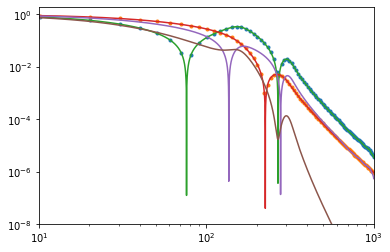

In [174]:
corrs=np.loadtxt(open('./correlations.dat'), delimiter="\t")

cparint=int1d(corrs[:,0],corrs[:,1],kind=9)
cperpint=int1d(corrs[:,0],corrs[:,2],kind=9)

xlis=corrs[:,0]

x_ary = np.arange(0, 1000, .001)
cpar_ary = cparint(x_ary) 
cperp_ary = cperpint(x_ary) 

plt.xlim(10,10**3)
plt.ylim(10**(-8),2)
plt.loglog(corrs[:,0],np.abs(corrs[:,1]),'.')
plt.loglog(corrs[:,0],np.abs(corrs[:,2]),'.')
plt.loglog(x_ary,np.abs(cpar_ary),'-')
plt.loglog(x_ary,np.abs(cperp_ary),'-')
plt.loglog(x_ary,np.abs((2*cperp_ary+cpar_ary)/3),'-')
plt.loglog(x_ary,(2*cperp_ary**2+cpar_ary**2)/3,'-')

# Generate $\Delta_v^2$ and $\Delta_{v^2}^2$

The relationship between the Fourier transformation of $\langle v^i v^j \rangle$ with $c_\parallel$ and $c_\perp$ is
$$
    c_\parallel(x) = \frac{1}{\sigma_{3d}^2} \int \frac{dk}{k} \Delta_{v_\text{rel}}^2(k) (j_0(kx) - 2 j_2(kx)) \qquad c_\perp(x) = \frac{1}{\sigma_{3d}^2} \int \frac{dk}{k} \Delta_{v_\text{rel}}^2(k) (j_0 (kx) + j_2(kx))
$$
$\Delta_{v_{bc}^2}$ is the dimensionless power spectrum, which is related to $\langle \mathcal{V}(\vec{k}) \mathcal{V}(\vec{k}')^* \rangle$ by 
$$
    \Delta_{v_\text{rel}}^2 = \frac{k^3}{2\pi^2} P_{v_{bc}}(k) = \frac{k^3}{2 \pi^2} (2\pi)^3 \delta_D(\vec{k}' - \vec{k}) P_{v_{bc}}(k)
$$


From the expressions above, we see that 
$$
\begin{alignat*}{1}
    c_\parallel(x) + 2 c_\perp(x) &= \frac{3}{\sigma_{3d}^2} \int \frac{dk}{k} \Delta_{v_{bc}}^2(k) j_0 (kx) \\ 
    &= \frac{1}{\sigma_{1d}^2} \int \frac{dk}{k} \frac{k^3}{2\pi^2} P_{v_{bc}}(k) \frac{\sin(kr)}{kr} \\
    &= \frac{1}{\sigma_{1d}^2} \int \frac{d^3 \vec{k}}{(2\pi)^3} e^{i\vec{k} \cdot \vec{x}} P_{v_{bc}}(k)
\end{alignat*}
$$
i.e. 
$$
\begin{alignat*}{1}
    P_{v_{bc}} &= \sigma_{1d}^2 \int d^3 \vec{x} e^{-i \vec{k} \cdot \vec{x}} [c_\parallel(x) + 2 c_\perp(x)] = \sigma_{1d}^2 \int d^3 \vec{x}  [c_\parallel(x) + 2 c_\perp(x)] j_0(kx) \\
    \Delta_{v_{bc}} &= \frac{k^3}{2 \pi^2} \sigma_{1d}^2 \int d^3 \vec{x}  [c_\parallel(x) + 2 c_\perp(x)] j_0(kx) \\
    &= \frac{2k^2}{\pi} \sigma_{1d}^2 \int dx [c_\parallel(x) + 2 c_\perp(x)] x \sin(kx)
\end{alignat*}
$$

We can also check that $\langle v^2(\vec{0}) v^2(\vec{x}) \rangle$ can be expanded through Wick expansion (see notes) to get
$$
    \langle v^2(\vec{0}) v^2(\vec{x}) \rangle - \sigma_{3d}^4 = \frac{2}{9} \sigma_{3d}^4 [c_\parallel^2 + 2 c_\perp^2]
$$
and we can define the Fourier transform of this quantity as $P_{v^2}$. 

In [4]:
start_time = time.time()
xiv_ary = (cpar_ary+2*cperp_ary)
xiv2_ary = 2*(cpar_ary**2+2*cperp_ary**2)

# klis=np.linspace(-3,1,300)
k_ary = np.logspace(-3, 1, num=300)

# Dimensionless. multiply sigma_1D^2 = 17**2 to get the right magnitude. 
Delta2_vrel  = np.array([2. / np.pi * k**2 * np.trapz(xiv_ary  * x_ary * np.sin(k * x_ary), x_ary) for k in k_ary])
# Dimensionless. multiply sigma_1D^4 = 17**4 to get the right magnitude. 
Delta2_vrel2 = np.array([2. / np.pi * k**2 * np.trapz(xiv2_ary * x_ary * np.sin(k * x_ary), x_ary) for k in k_ary]) 
# Delta2_vrel  = 2. / np.pi * k_ary[:, None] ** 2 * np.trapz(xiv[None, :] * x_ary[None, :] * np.sin(k_ary[:, None] * x_ary[None, :]), x_ary)
# Delta2_vrel2 = 2. / np.pi * k_ary[:, None] ** 2 * np.trapz(xiv2[None, :] * x_ary[None, :] * np.sin(k_ary[:, None] * x_ary[None, :]), x_ary)

# a = []
# for i in range(300):
#     a.append(2*np.pi**(-1)*10**(2*klis[i])*np.trapz(xiv*xnew*np.sin(10**klis[i]*xnew),xnew))
    
    
# b=[]
# for i in range(300):
#     b.append(2*np.pi**(-1)*10**(2*klis[i])*np.trapz(xiv2*xnew*np.sin(10**klis[i]*xnew),xnew))
    
time.time()-start_time

18.126219987869263

Text(0, 0.5, '$\\Delta^2$ [km$^4$ s$^{-4}$]')

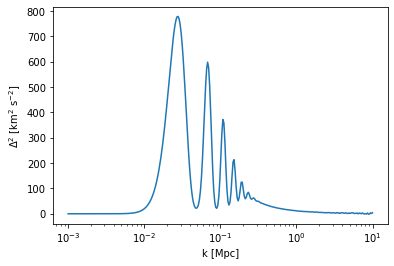

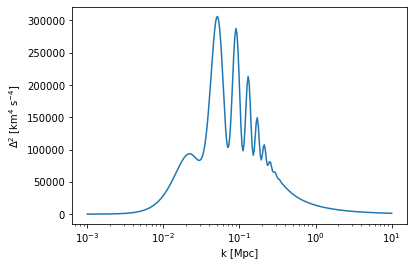

In [311]:
plt.figure()

plt.semilogx(k_ary,np.array(Delta2_vrel) * (17)**2)
# plt.loglog(k_ary,np.array(Delta2_vrel) * (17)**2)

plt.xlabel(r'k [Mpc]')
plt.ylabel(r'$\Delta^2$ [km$^2$ s$^{-2}$]')

plt.figure()

plt.semilogx(k_ary,np.array(Delta2_vrel2) * (17)**4)


plt.xlabel(r'k [Mpc]')
plt.ylabel(r'$\Delta^2$ [km$^4$ s$^{-4}$]')

We can check the normalization of these quantities. First, $P_{v_{bc}}$ is the Fourier transform of $\langle v^i(\vec{0}) v_i(\vec{x}) \rangle$ as well. And so
$$
    \int \frac{d^3 \vec{k}}{(2\pi)^3} P_{v_{bc}} = \int \frac{d^3 \vec{k}}{(2\pi)^3} \frac{2 \pi^2}{k^3} \Delta_{v_{bc}}^2 = \int \frac{dk}{k} \Delta_{v_{bc}}^2 = \langle v^2 \rangle = \sigma_{3d}^2
$$
Similarly, 
$$
    \int \frac{d^3 \vec{k}}{(2\pi)^3} P_{v^2} = \int \frac{dk}{k} \Delta_{v^2}^2 = \langle v^4 \rangle - \sigma_{3d}^4 = \frac{2}{3} \sigma_{3d}^4
$$

In [6]:
# Delta2_vrel is dimensionless: this integral should be sigma_3D^2 / sigma_1D^2 = 3
norm_Delta2_vrel = np.trapz(Delta2_vrel / k_ary, k_ary) 
print(norm_Delta2_vrel)

# Delta_vrel2 is dimensionless: this integral should be (2/3) sigma_3D^4 / sigma_1D^4 = 6
norm_Delta2_vrel2 = np.trapz(Delta2_vrel2 / k_ary, k_ary) 
print(norm_Delta2_vrel2)


2.996363092055103
5.985097550638372


# Calculating $\Delta_T^2$ for a given dist

We are going to be integrating stuff over the gaussian PDF of velocities. In particular, 
$$
    f(\vec{v}) = \prod_{i = x,y,z}\frac{1}{\sqrt{2 \pi \sigma_{1d}^2}} e^{-v_i^2 / 2 \sigma_{1d}^2} = \frac{1}{(2 \pi \sigma_{1d}^2)^{3/2}} e^{- v^2/2 \sigma_{1d}^2} = \left( \frac{3}{2 \pi} \right)^{3/2} \frac{1}{\sigma_{3d}^3} e^{-3v^2 / 2\sigma_{3d}^2}
$$

With this, we can compute the mean and variance:
$$
    \langle g \rangle = \int dv \, 4\pi v^2 f(\vec{v}) g \quad \langle (g - \langle g \rangle)^2 \rangle = \langle g^2 \rangle - \langle g \rangle^2 = \int dv \, 4\pi v^2 f(\vec{v}) (g - \langle g \rangle)^2
$$

We also need
$$
    b[f] = \frac{3}{2} \left[ 1 - \frac{\langle v^2 f \rangle}{\langle f \rangle \sigma_{3d}^2} \right]
$$

In [7]:
# 3D MB velocity dist with vrms = 29 [km/sec]
def MB(v):
    return np.sqrt(27/(8*np.pi**3))/(29**3)*np.exp(-3*v**2/(2*29**2))

# Mean of f(v)
def Meanf(fv,v):
    return 4*np.pi*np.trapz(MB(v)*v**2*fv,v)

# Variance of f(v)
def Varf(fv,v):
    f_mean = Meanf(fv,v)
    return 4*np.pi*np.trapz(MB(v)*v**2*(fv - f_mean)**2,v)
#     return 4*np.pi*np.trapz(MB(v)*v**2*fv**2,v)-Meanf(fv,v)**2

# This is now b^2 <f>^2
def b2f(fv,v):
    Vrms_sq = Meanf(v**2, v)
#     return (9/4)*(4*np.pi*np.trapz(MB(v)*v**2*fv*(1 - v**2/Vrms_sq), v))**2
    return (9/4)*(Meanf(fv,v)-4*np.pi*np.trapz(MB(v)*v**4*fv,v) / Vrms_sq)**2

In [8]:
# Calculation of x_A,eff. 

# Reading in Matlab data

import scipy.io
xA_param = scipy.io.loadmat('xA_from_Anastasia/PT_LyACMB_NoRad.mat')
xA_data = scipy.io.loadmat('xA_from_Anastasia/xA_LyACMB_NoRad.mat')

# These are the entries where X-ray heating is small. Pick any of these indices. 
print(np.argwhere(xA_param['PTout'][:,3] < 1e-3).flatten()[-7:])
ind = 3165

# print(xA_param['PTout'].shape)
print(xA_param['PTout'][ind, :])

xA_z_ary = np.arange(6., 51.)

xA_ary = xA_data['xAout'][ind] 

# In preparation for log-interpolation
xA_ary[xA_ary <= 0] = 1e-100

log10_xA_int = int1d(xA_z_ary, np.log10(xA_ary))


[3165 3170 3171 3175 3182 3184 3187]
[5.10000000e+01 5.07275945e-03 5.37631115e+00 1.03444222e-04
 1.00000000e+00 4.00000000e-01 2.94782186e+01 7.77867823e-02
 0.00000000e+00]


In [9]:
# plt.figure()

# plt.loglog()

# for i in np.argwhere(xA_param['PTout'][:,3] < 1e-3).flatten()[-7:]:

#     plt.plot(xA_z_ary, xA_data['xAout'][i,:])

# plt.axis([10, 30, 1e-5, 10])

In [10]:
# Baryon temperature data. 

Vlis = np.loadtxt(open('./Tb_dat/Vlis.csv'), delimiter=",")
Qlis = np.loadtxt(open('./Tb_dat/Qlis.csv'), delimiter=",")
Tbarr= np.loadtxt(open('./Tb_dat/Tb17_mc100MeV_mm100MeV.csv'), delimiter=",")



Tblis=Tbarr[70,:] * 1e3 # in mK

In [11]:
# Calculation of xA_eff (see 1605.04357 Eq. 57)

T_se = 402. # in mK
T_star = 68.2 # in mK, equivalent temperature of hyperfine splitting
A10 = 2.85e-15 # in s^-1, spontaneous decay rate of hyperfine transition

xA_z_17 = 10**log10_xA_int(17.)
print(xA_z_17)
xA_eff = xA_z_17 / (1 + T_se / Tblis) * np.exp(
    -2.06 * (Omega_b_h / 0.0327)**(1/3) * (Omega_m / 0.307)**(-1/6) * np.sqrt(18. / 10) * (Tblis / T_se)**(-2/3)
)

# Calculation of xc (see 1605.04357 Eq. 46, taken from Zygelman: https://iopscience.iop.org/article/10.1086/427682/pdf)

# in mK
T_kappa_10_ary = np.array([1., 2., 4., 6., 8., 10., 15., 20., 25., 30., 40., 50., 60., 70., 80., 90., 100., 200., 300.]) * 1e3

# in cm^3 / sec
kappa_10_ary = np.array([1.38e-13, 1.43e-13, 2.71e-13, 6.60e-13, 1.47e-12, 2.88e-12, 9.10e-12, 1.78e-11, 2.73e-11, 3.67e-11, 5.38e-11, 6.86e-11, 8.14e-11, 9.25e-11, 1.02e-10, 1.11e-10, 1.19e-10, 1.75e-10, 2.09e-10])

log10_kappa_10_int = int1d(T_kappa_10_ary, np.log10(kappa_10_ary), bounds_error=False, fill_value=(np.log10(1.38e-13), np.log10(2.09e-10)))

# Tblis is in 
xc = 4 * 10**log10_kappa_10_int(Tblis) * nH * (18. ** 3) * T_star / 3. / A10 / (T_0 * 18.)

x_tot_eff = xc + xA_eff 


3.414766541199489


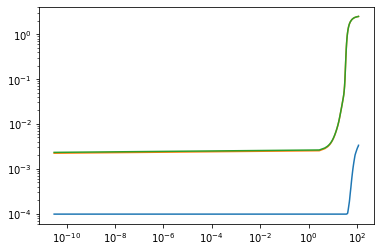

In [12]:
plt.figure()

plt.loglog()

plt.plot(Vlis, xc)
plt.plot(Vlis, xA_eff)
plt.plot(Vlis, x_tot_eff)

In [13]:


# Old T21
# T21lis = 36*(1-49.095/Tblis)

# With the approximation that tau is small, should be (T_s - T_R)/(1+z)*tau in mK (see 1605.04357 Eq. 40 for the prefactor)
# We also introduce the x_tot,eff / (1 + x_tot,eff) factor to go between 1 - TCMB/TS and 1 - TCMB/TK (1605.04357 Eq. 56)
T21lis_small_tau = 26.8 * (Omega_b_h / 0.0327) * (Omega_m / 0.307)**(-0.5) * np.sqrt(18. / 10.) *  (1-T_0 * 18./Tblis)

# The actual value of tau, from the expression above. T21lis_small_tau is in mK. 
tau = T21lis_small_tau * 18. / (Tblis - T_0 * 18.)

# Actual T21 is (T_s - T_R)/(1+z) * (1 - exp(-tau)). Given in mK. 
T21lis = (Tblis - T_0 * 18.) / 18. * (1. - np.exp(-tau))

T21int=int1d(Vlis,T21lis,kind=2)

meanT, varT, b2T= Meanf(T21lis,Vlis), Varf(T21lis,Vlis), b2f(T21lis,Vlis)

dT2=Meanf((np.diff(T21lis)/np.diff(Vlis))**2,Vlis[1:])*29**2


In [14]:
# print(T21lis)
print(meanT)
print(varT)
print(b2T)

-2118.365460823764
559021.0548200036
735905.3385522611


### Approximated correlations
#### Using our dimensionless notation we have 
$\xi_T(x)\simeq b_T^2\xi_{v_{\text {rel }}^{2}}(x)/9$ for lare x, and
$\operatorname{Var}[f]+\frac{1}{4}\left[\frac{\xi_{v_{\text {rel }}^{2}}(x)}{9}-\frac{2}{3}\right] \left\langle \left(V_{\mathrm{rms}}f^{\prime}\right)^{2}\right\rangle$ for small x

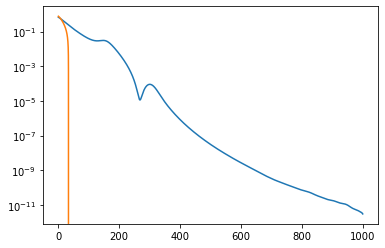

In [15]:
xiTlarge=xiv2_ary/9
xiTsmall=varT/b2T+(dT2/(4*b2T))*(xiv2_ary/9-2/3)
xiTtot=np.maximum(xiTlarge,xiTsmall)

# plt.xlim(0,30)
# plt.ylim(0.1,3)
plt.semilogy(x_ary,xiTlarge)
plt.semilogy(x_ary,xiTsmall)

# plt.axis([0, 1, 0.1, 10])

### PS calculation (probably bad!)

In [16]:
# DelT2app=[];
# for i in range(300):
#     DelT2app.append(9*2*np.pi**(-1)*10**(2*klis[i])*np.trapz(xiTtot*xnew*np.sin(10**klis[i]*xnew),xnew))
    
# plt.semilogx(10**klis,b)
# plt.semilogx(10**klis,DelT2app)

# Full numerical calc

In [73]:
sig1=29/np.sqrt(3)
ulis=Vlis/sig1
ulis=np.linspace(ulis[0],ulis[-1],70)
zlis=np.linspace(-1,1, 50)

In [74]:
def R(z,x):
    
    return np.sqrt(cperpint(x)**2+(cparint(x)**2-cperpint(x)**2)*z**2)

def R_vec(z,x):
    
    term_1 = cperpint(x)**2 
    term_2 = np.outer(z**2, cparint(x)**2 - cperpint(x)**2)
    return np.sqrt(term_1 + term_2)

def dW(u1,u2,z,x):
    
    return (
        (u1*u2/np.pi)*(R(z,x)*np.sqrt(1-R(z,x)**2))**(-1)
        * 0.5 * np.exp(-(u1**2 - 2*R(z,x)*u1*u2 + u2**2)/(2*(1 - R(z,x)**2))) 
        * (1. - np.exp(-2*R(z,x)*u1*u2/(1 - R(z,x)**2)))
    )

def dW_vec(u1,u2,z,x):
    
    one_minus_R_sq   = 1. - R_vec(z,x)**2
    
    u1_sq_plus_u2_sq = np.outer(u1**2, np.ones_like(u2)) + np.outer(np.ones_like(u1), u2**2)
    
    term_1  = np.einsum('i,j,kl->ijkl',u1,u2,1./(R_vec(z,x)*np.sqrt(one_minus_R_sq))) / np.pi
    term_2a_exp = np.einsum('ij,kl->ijkl', -u1_sq_plus_u2_sq, 1./(2*one_minus_R_sq))
    term_2b_exp = np.einsum('i,j,kl->ijkl', u1, u2, 2*R_vec(z,x)/(2*one_minus_R_sq))
    term_2 = 0.5*np.exp(term_2a_exp + term_2b_exp)
    term_3 = 1. - np.exp(-2*term_2b_exp)
    
    dW_zero_R = np.einsum(
        'ij,i,j,kl->ijkl',
        np.exp(-u1_sq_plus_u2_sq/2) / np.pi, u1**2, u2**2, np.ones_like(one_minus_R_sq)
    )
    
#     print(term_1)
#     print(term_2)
#     print(term_3)
#     print('before subtraction: ', term_1*term_2*term_3)
#     print('term to subtract: ', dW_zero_R)
    
    large_R_term = term_1*term_2*term_3 - dW_zero_R
    
#     print(large_R_term[9, 9, :, :])
#     print('large R: ', large_R_term)
    
    small_R_term = np.einsum(
        'ij,i,j,kl->ijkl',
        np.exp(-u1_sq_plus_u2_sq/2) / 6./ np.pi, u1**2 * (u1**2 - 3.), u2**2 * (u2**2 - 3), R_vec(z,x)**2
    )
    
#     print('small R: ', small_R_term)
    
    mask = np.zeros_like(large_R_term)
    mask[...,:,:] = R_vec(z,x)
    
    large_R_mask = np.ones_like(mask)
    small_R_mask = np.ones_like(mask)
    
    large_R_mask[mask < 0.1] *= 0
    small_R_mask[mask >= 0.1] *= 0
    
#     print('R_vec: ', R_vec(z,x))
#     print('large_R_mask: ', large_R_mask)
#     print('small_R_mask: ', small_R_mask)
    
    final_res = large_R_term*large_R_mask + small_R_term*small_R_mask
    
#     print(final_res)
    
    return final_res
    
def dff(u1,u2,z,x):
    
    return dW(u1,u2,z,x)*T21int(u1*sig1)*T21int(u2*sig1)

def dff_vec(u1,u2,z,x):
    
    return np.einsum('ijkl,i,j->ijkl',dW_vec(u1,u2,z,x), T21int(u1*sig1), T21int(u2*sig1))




In [595]:
x_small_ary = np.arange(0, 30, 0.1)

xiv2_small_ary = 2*(cparint(x_small_ary)**2 + 2 * cperpint(x_small_ary)**2)

xiT_small_ary = varT + dT2 / 4 * (xiv2_small_ary/9-2/3)

xiT_small_int = int1d(x_small_ary, xiT_small_ary, kind=9)

x_computed_ary = np.logspace(-1, 2., num=200)

xiT_computed_ary = np.trapz(
    np.trapz(
        np.trapz(
            dff_vec(ulis, ulis, zlis, x_computed_ary), zlis, axis=-2
        ),
        ulis, axis=-2
    ),
    ulis, axis=-2
)

xiT_computed_int = int1d(x_computed_ary, xiT_computed_ary, kind=9)

# x_large_ary = np.logspace(1, 3, num=1000)
x_large_ary = np.concatenate((
    np.logspace(1, 2, num=100)[:-1],
    np.logspace(2, np.log10(350), num=10000),
    np.logspace(np.log10(350), 3, num=100)[1:]
))

xiT_large_ary = 2 * (cparint(x_large_ary)**2 + 2*cperpint(x_large_ary)**2) * b2T / 9

xiT_large_int = int1d(x_large_ary, xiT_large_ary, kind=9)

def xiT(x, x_switch=90): 

    xiT_small    = xiT_small_int(x[x < 1])
    xiT_computed = xiT_computed_int(x[(x >= 1) & (x < x_switch)])
    xiT_large    = xiT_large_int(x[(x >= x_switch) & (x <= 1e3)]) 
    xiT_exceed   = np.zeros_like(x[x > 1e3])

    return np.concatenate((xiT_small, xiT_computed, xiT_large, xiT_exceed))

# x_full_ary = np.arange(0, 1000, 0.0005)
x_full_ary = np.concatenate((
    np.logspace(-5, np.log10(1e2), num=50000)[:-1], 
    np.logspace(np.log10(1e2), np.log10(4e2), num=200000),
    np.logspace(np.log10(4e2), 5, num=50000)[1:]
))

xiT_new_ary = xiT(x_full_ary)

# # Use the FFT to compute 
# DelTTn = -np.imag(np.fft.fft(xiT_new_ary * x_full_ary * (x_full_ary[1] - x_full_ary[0])))

# kout   = np.arange(x_full_ary.size) * 2*np.pi / (x_full_ary[1] - x_full_ary[0]) / x_full_ary.size
# DelTTn *= 2/np.pi*kout**2

kout = np.logspace(-2, 1, num=230)

# P_T = 4. * np.pi * np.trapz(x_full_ary ** 2 * xiT_new_ary[None,:] * spherical_jn(0, kout[:,None] * x_full_ary[None,:]), x_full_ary)
P_T = np.array([4 * np.pi * np.trapz(x_full_ary ** 2 * xiT_new_ary * spherical_jn(0, k*x_full_ary), x_full_ary) for k in kout])

DelTTn = P_T * kout**3 / (2 * np.pi**2)




In [608]:
# Range of periodic interval
logrmin = -4
logrmax = 4

# Number of points (Max 4096)
n = 4096

# Order mu of Bessel function
mu = 0.5

# Index of x, x^alpha to try to compute transform. The bias is then 3/2 - alpha
alpha = 1.5

# Bias exponent: q = 0 is unbiased
q = 1.5 - alpha

# Sensible approximate choice of k_c r_c
kr = 1

# Tell fhti to change kr to low-ringing value
# WARNING: kropt = 3 will fail, as interaction is not supported
kropt = 1

# Forward transform (changed from dir to tdir, as dir is a python fct)
tdir = 1

# Central point log10(r_c) of periodic interval
logrc = (logrmin + logrmax)/2

print(f"Central point of periodic interval at log10(r_c) = {logrc}")

# Central index (1/2 integral if n is even)
nc = (n + 1)/2.0

# Log-spacing of points
dlogr = (logrmax - logrmin)/n
dlnr = dlogr*np.log(10.0)

# function to log-Fourier transform
r = 10**(logrc + (np.arange(1, n+1) - nc)*dlogr)
# this gives Delta^2_TT at the end of the transform. 
ar_DelTTn = np.sqrt(2 / np.pi) * xiT(r) * r**alpha

xiv2_ary = np.concatenate((
    2 * (cparint(r[r <= 1e3])**2 + 2 * cperpint(r[r <= 1e3])**2),
    np.zeros_like(r[r > 1e3])
))

ar_xiv2 = np.sqrt(2 / np.pi) * xiv2_ary * r**alpha 

kr, xsave = pyfftlog.fhti(n, mu, dlnr, q, kr, kropt)
print(f"pyfftlog.fhti: new kr = {kr}")

logkc = np.log10(kr) - logrc
print(f"Central point in k-space at log10(k_c) = {logkc}")

# rk = r_c/k_c
rk = 10**(logrc - logkc)

# Transform
k = 10**(logkc + (np.arange(1, n+1) - nc)*dlogr)
ak_DelTTn = k**alpha * pyfftlog.fht(ar_DelTTn.copy(), xsave, tdir) 
ak_xiv2   = k**alpha * pyfftlog.fht(ar_xiv2.copy(), xsave, tdir)



Central point of periodic interval at log10(r_c) = 0.0
pyfftlog.fhti: new kr = 1.0005567620512366
Central point in k-space at log10(k_c) = 0.0002417313993929534


(0.5, 500)

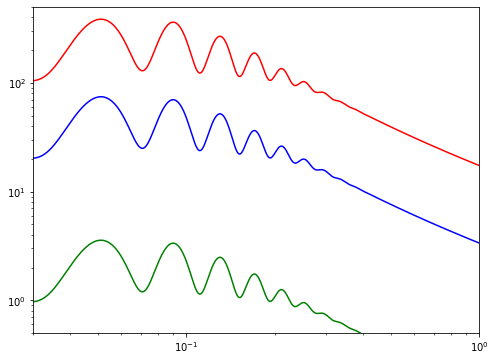

In [609]:
plt.figure(figsize=(8,6))

# plt.loglog(r, ar)

# Attempting to reproduce Julian+
plt.loglog(k, ak_xiv2 * ((0.6 + 0.3 * np.log(0.03/1e-2))*17)**4 * (4.4 * 0.03**(4/3))**2 , color='red')
plt.loglog(k, ak_xiv2 * ((0.6 + 0.3 * np.log(0.02/1e-2))*17)**4 * (4.4 * 0.02**(4/3))**2 , color='blue')
plt.loglog(k, ak_xiv2 * ((0.6 + 0.3 * np.log(0.01/1e-2))*17)**4 * (4.4 * 0.01**(4/3))**2 , color='green')


# plt.loglog(kout, DelTTn / (b2T / 9), color='red')

plt.xlim(3e-2, 1)
plt.ylim(0.5, 500)

Text(0.5, 1.0, '$m_m$ = 100 MeV, $Q = 0.04$')

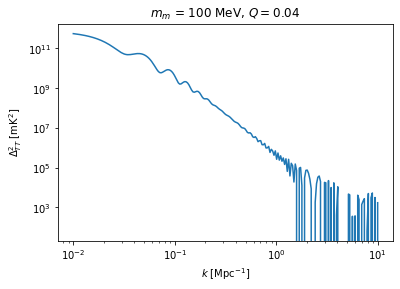

In [348]:
# plt.loglog(10**klis,DelTTn_old)
plt.loglog(kout,P_T)
# plt.plot(kout, P_T)
# plt.yscale('log')
# plt.loglog(10**klis,b) 

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta_{TT}^2$ [mK$^2$]')

# plt.title(r'$m_m$ = 100 MeV, $Q = 5.4 \times 10^{-4}$')

plt.title(r'$m_m$ = 100 MeV, $Q = 0.04$')

# plt.axis([3e-2, 5, 1e2, 1e7])

Text(0.5, 1.0, '$m_m$ = 100 MeV, $Q = 0.04$')

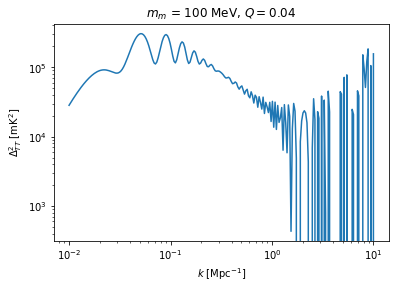

In [343]:
# plt.loglog(10**klis,DelTTn_old)
plt.loglog(kout,DelTTn)
# plt.plot(kout, DelTTn)
# plt.loglog(10**klis,b) 

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta_{TT}^2$ [mK$^2$]')

# plt.title(r'$m_m$ = 100 MeV, $Q = 5.4 \times 10^{-4}$')

plt.title(r'$m_m$ = 100 MeV, $Q = 0.04$')

# plt.axis([1e-2, 6e-1, 1e2, 1e7])

(100.0, 1000.0)

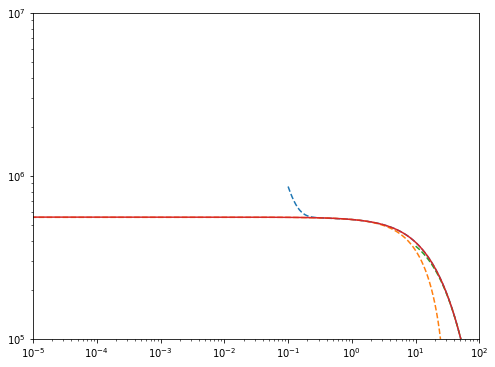

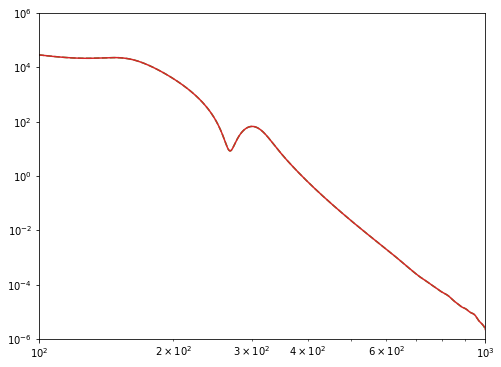

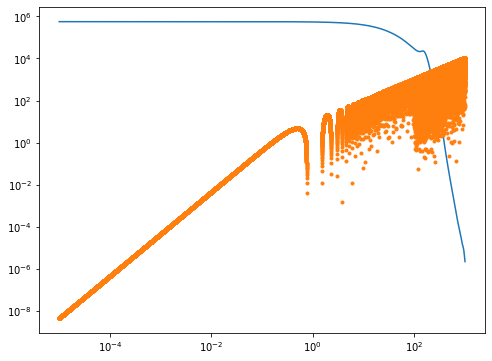

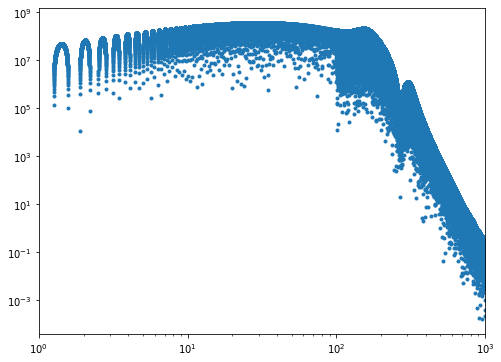

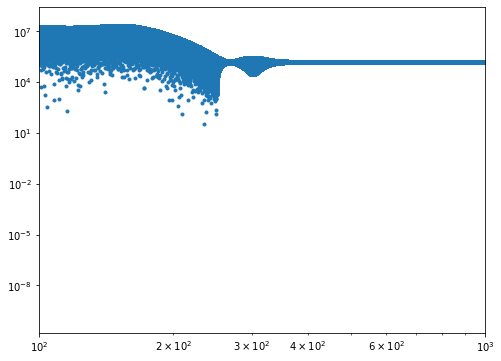

In [346]:
plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_computed_ary, xiT_computed_ary, '--')
plt.plot(x_small_ary,    xiT_small_ary, '--')
plt.plot(x_large_ary,    xiT_large_ary, '--')
plt.plot(x_full_ary,     xiT_new_ary)
# plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[200]*x_full_ary), '.')

plt.axis([1e-5, 1e2, 1e5, 1e7])

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_computed_ary, xiT_computed_ary)
plt.plot(x_small_ary,    xiT_small_ary, '--')
plt.plot(x_large_ary,    xiT_large_ary, '--')
plt.plot(x_full_ary,     xiT_new_ary)
# plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[200]*x_full_ary), '.')

plt.axis([1e2, 1e3, 1e-6, 1e6])
# plt.axis([2e2, 4e2, 1e0, 1e2])

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_full_ary,     xiT_new_ary)
plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[200]*x_full_ary) * kout[200]**3 / (2 * np.pi**2), '.')


ind = -1

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[ind]*x_full_ary) * xiT_new_ary * kout[ind]**3 / (2 * np.pi**2), '.')

plt.xlim(1, 1e3)
# plt.ylim(1e4, 1e7)

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_full_ary[:-1], 4 * np.pi * integrate.cumtrapz(x_full_ary ** 2 * spherical_jn(0, kout[ind]*x_full_ary) * xiT_new_ary, x_full_ary) * kout[ind]**3 / (2 * np.pi**2), '.')

plt.xlim(1e2, 1e3)
# plt.ylim(1e2, 1e7)
